# Source code

In [1]:
%load_ext autoreload
%aimport cbc_dp, cbc
import matplotlib
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pyqtgraph as pg
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.ndimage.measurements import label, maximum_position, center_of_mass
from scipy import constants
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

In [2]:
peaks_path = "exp_results/scan_{0:05}/scan_peaks_{0:05}.h5"
cor_path = "exp_results/scan_{0:05}/scan_corrected_{0:05}.h5"
bgd_path = 'corrected_data/background'
cor_data_path = 'corrected_data/corrected_data'
strks_path = 'corrected_data/streaks_data'
data_path = 'data/data'
mask_path = 'data/mask'
lines_path = 'peaks_data/bragg_lines'
ints_path = 'peaks_data/bragg_intensities'
# pupil_roi = ROI(np.array([1070, 1250, 1250, 1600]))
pupil_size = np.radians([0.74, 1.6])
# lys_roi = ROI(np.array([500, 1767, 800, 2070]))
# b12_roi = ROI(np.array([700, 2167, 600, 2070]))
# full_roi = ROI(np.array([0, 2167, 0, 2070]))
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = np.array([0, 1, 0])
b12_sizes = np.array([16.18, 21.23, 24.33]) * 1e-7
b12_rec_sizes = b12_sizes**-1 * wavelength
b12_det_pos = np.array([1470 * pix_size, 1710 * pix_size, 101.976])
lys_det_pos = np.array([1480 * pix_size, 1155 * pix_size, 150.0])
b12_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_pos=b12_det_pos,
                                    wavelength=wavelength)
lys_exp = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_pos=lys_det_pos,
                                    wavelength=wavelength)

In [3]:
f135 = h5py.File(cor_path.format(135), 'r')
b12_cor_data = f135[cor_data_path]
b12_data = f135[data_path]
b12_mask = f135[mask_path][:]
b12_bgd = f135[bgd_path]
b12_strks_data = f135[strks_path][:]

In [5]:
f107 = h5py.File(cor_path.format(107), 'r')
lys_cor_data = f107[cor_data_path]
lys_bgd = f107[bgd_path]
lys_strks_data = f107[strks_path][:]

In [8]:
f133 = h5py.File(cor_path.format(133), 'r')
b12_cor_data2 = f133[cor_data_path]
b12_bgd2 = f133[bgd_path]
b12_strks_data2 = f133[strks_path][:]

# Line detection

In [42]:
strks = b12_strks_data[0]
image = b12_cor_data[0]
nms = cbc_dp.utils.nonmax_supression(strks.astype(np.float))
hough_det = cbc_dp.LineSegmentDetector()
lsd = cbc_dp.LineSegmentDetector(sigma_scale=0.2, scale=0.9)
lsd.det_frame(strks, b12_exp).size, b12_scan[0].size

(90, 81)

In [43]:
strks_list = []
strks_list.append(hough_det.det_frame(strks, b12_exp))
strks_list.append(hough_det.det_frame(nms, b12_exp))
strks_list.append(lsd.det_frame(strks, b12_exp))
strks_list.append(lsd.det_frame(nms, b12_exp))
pts_list = [strks.index_pts() for strks in strks_list]

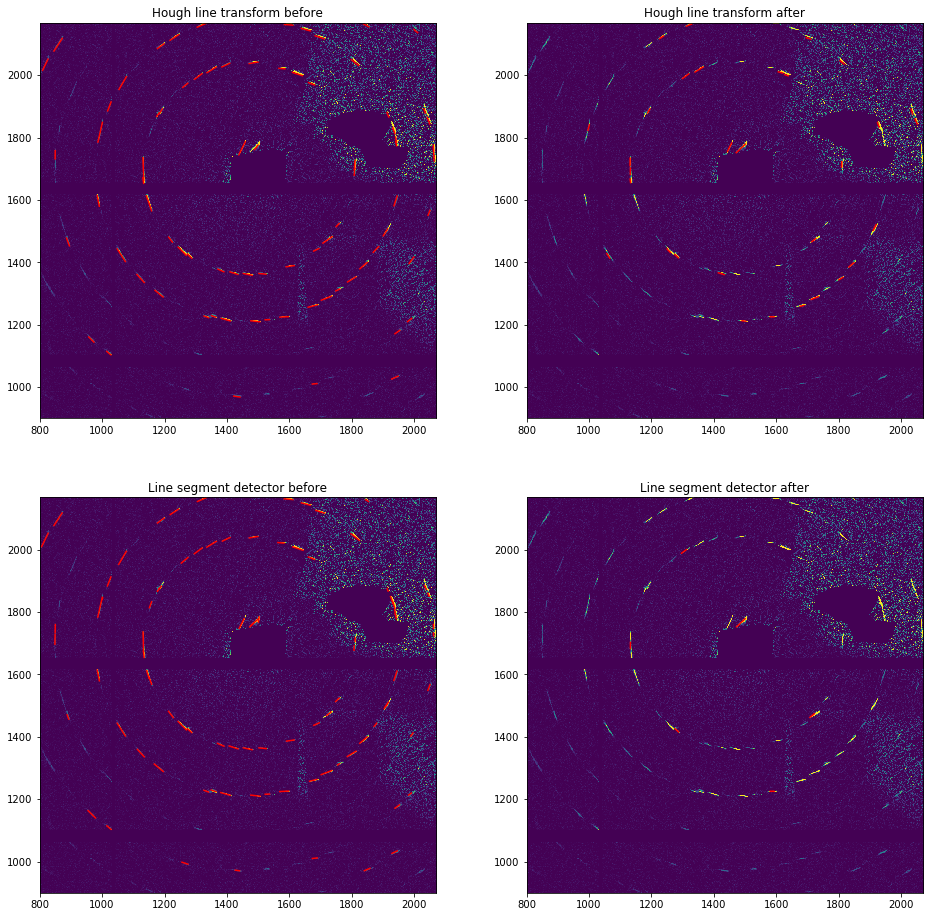

In [44]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
titles = ['Hough line transform before', 'Hough line transform after', 'Line segment detector before', 'Line segment detector after']
for ax, lines, pts, title in zip(axes.ravel(), strks_list, pts_list, titles):
    ax.imshow(image, vmin=0, vmax=100)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'r')  
    ax.scatter(pts[:, 0], pts[:, 1])
    ax.set_xlim(800, 2070)
    ax.set_ylim(900, 2167)
    ax.set_title(title)
plt.show()

# Indexing

In [228]:
lsd = cbc_dp.LineSegmentDetector()
thetas = np.radians(np.arange(101))
b12_scan = lsd.det_scan(b12_strks_data, b12_exp)

In [230]:
b12_qs = b12_scan.kout_ref(theta=thetas)
basis_full = b12_qs.index()
or_mat_full = cbc.rec_or_mat(basis_full)

In [247]:
frame_idx = 80
qs_frame = b12_scan[frame_idx].kout(theta=0)
basis_frame = qs_frame.index()
or_mat_frame = cbc.rec_or_mat(basis_frame)
model_frame = cbc_dp.CircModel(cbc_dp.RecLattice(or_mat_frame), np.radians(1.), 0.4)
det_pts_frame = model_frame.det_pts(b12_exp)

rot_m = b12_exp.rotation_matrix(np.radians(-frame_idx))
or_rot = or_mat_full.dot(rot_m.T)
model = cbc_dp.CircModel(cbc_dp.RecLattice(or_rot), np.radians(1.), 0.4)
det_pts_full = model.det_pts(b12_exp)

In [17]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=b12_qs.scat_vec, size=3)
w.show()

In [32]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.VolumeViewer()
w.set_data(data=cbc_dp.Qt.vol_data(fft_crop))
w.show()

In [33]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=peaks, size=10)
w.show()

In [232]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=np.concatenate((basis, np.zeros((1, 3)))), size=10)
w.show()

In [243]:
b12_axes = np.array([[16.18, 0, 0],
                     [0, 21.23, 0],
                     [0, 0, 24.33]]) * 1e-7
for ax, b12_ax in zip(basis_full, b12_axes):
    print(np.sqrt(ax.dot(ax))**-1, wavelength / np.sqrt(b12_ax.dot(b12_ax)), sep='\t')

0.0466739501461924	0.0450753280725686
0.03218772842386179	0.03435321753246161
0.025726631078361272	0.029976112133750923


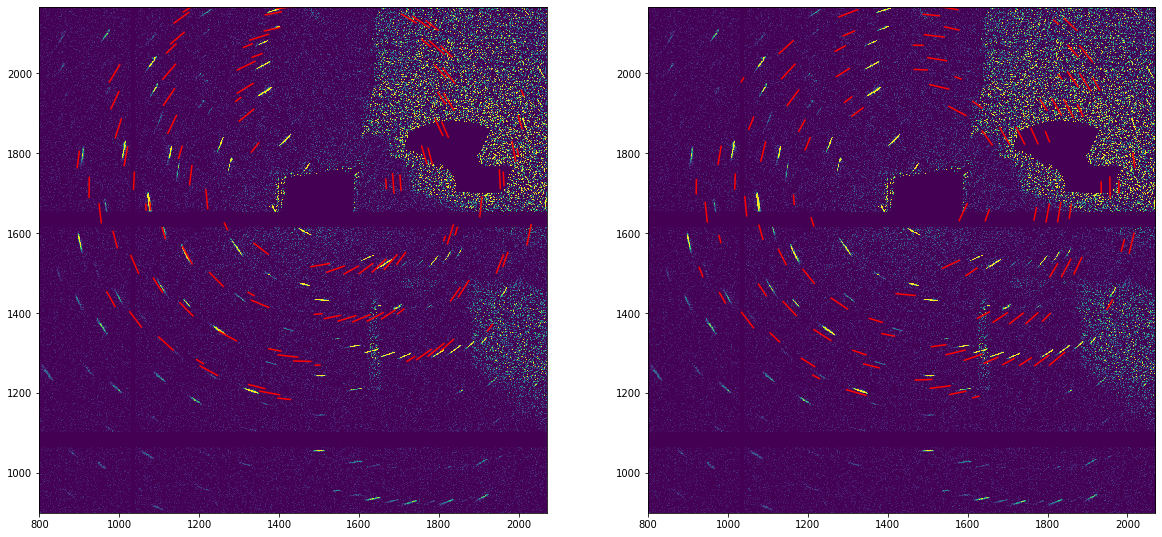

In [248]:
%matplotlib inline
fig, plt_axes = plt.subplots(1, 2, figsize=(20, 10))
for ax in plt_axes:
    ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
    ax.set_xlim(800, 2070)
    ax.set_ylim(900, 2167)
for line in det_pts_full:
    plt_axes[0].plot(line[:, 0], line[:, 1], 'r')
for line in det_pts_frame:
    plt_axes[1].plot(line[:, 0], line[:, 1], 'r')
plt.show()

In [42]:
frame_idxs = [80, 90]
or_mat = cbc.rec_or(exp_axes)
pts_list, sim_masks, exp_masks = [], [], []
hkls_sim, hkls_exp = [], []
for frame_idx in frame_idxs:
    rot_m = b12_exp.rotation_matrix(np.radians(-frame_idx))
    or_rot = or_mat.dot(rot_m.T)
    rec_lat = cbc_dp.RecLattice(or_rot, center=np.zeros(3))
    model = cbc_dp.CircModel(rec_lat=rec_lat, num_ap=np.radians(1.), q_max=0.4)
    pts_list.append(model.det_pts(b12_exp))
    idxs = slice(b12_scan.shapes[frame_idx], b12_scan.shapes[frame_idx + 1])
    hkl_exp = rec_lat.hkl_idx(b12_qs.scat_vec).astype(np.int)[idxs]
    hkl_sim = model.hkl_idx.astype(np.int)
    mask = (hkl_exp[:, None] == hkl_sim[None, :]).all(axis=2)
    hkls_sim.append(hkl_sim)
    hkls_exp.append(hkl_exp)
    sim_masks.append(mask.any(axis=0))
    exp_masks.append(mask.any(axis=1))

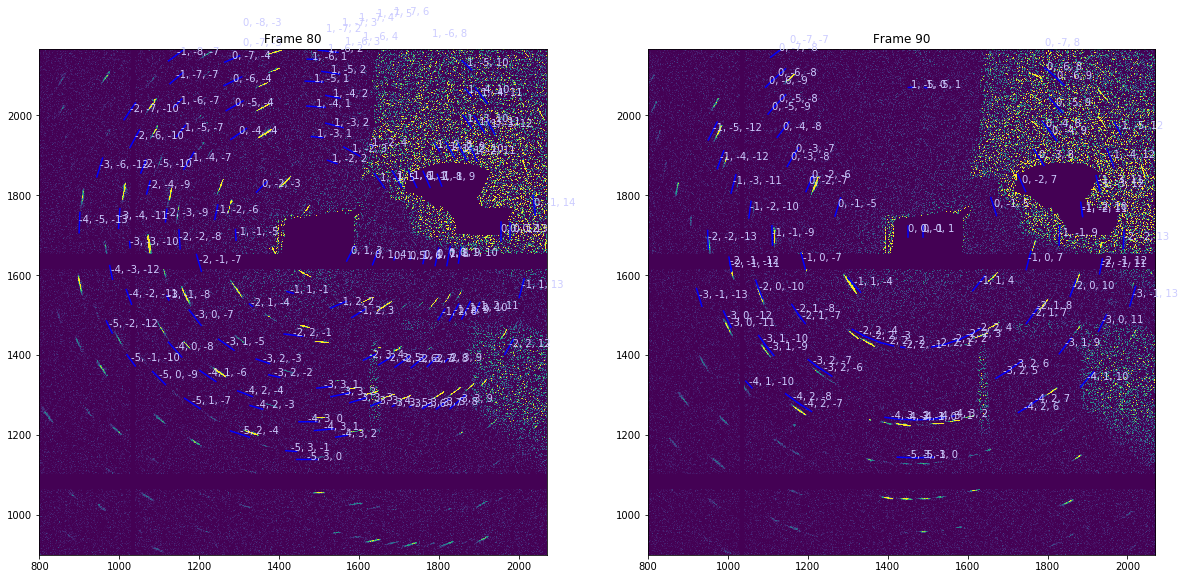

In [43]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for ax, det_pts, idx, hkl_sim, hkl_exp in zip(axes, pts_list, frame_idxs, hkls_sim, hkls_exp):
    for line, hkl in zip(b12_scan[idx].raw_lines, hkl_exp):
        ax.plot(line[:, 0], line[:, 1], 'r')
        ax.text(line[:, 0].mean(),
                line[:, 1].mean(),
                '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl),
                color=(1, 0.8, 0.8))
    for line, hkl in zip(det_pts, hkl_sim):
        ax.plot(line[:, 0], line[:, 1], 'b')
        ax.text(line[:, 0].mean(),
                line[:, 1].mean(),
                '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl),
                color=(0.8, 0.8, 1))
    ax.imshow(b12_cor_data[idx], vmin=0, vmax=50)
    ax.set_xlim(800, 2070)
    ax.set_ylim(900, 2167)
    ax.set_title('Frame {:d}'.format(idx))
plt.show()

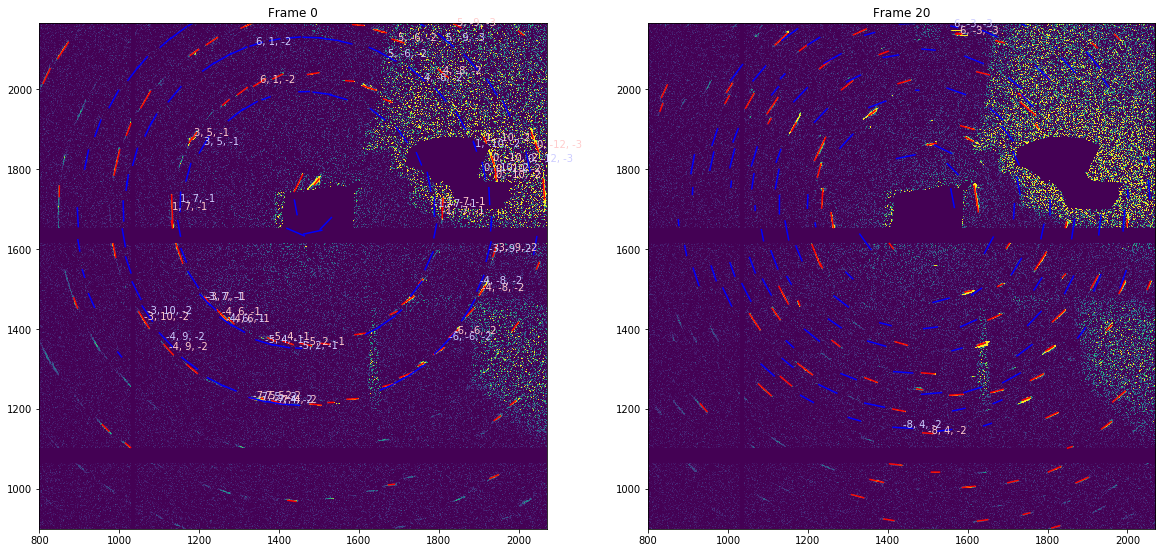

In [18]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for ax, det_pts, idx, hkl_sim, hkl_exp, sim_mask, exp_mask in zip(axes, pts_list, frame_idxs, hkls_sim,
                                                                  hkls_exp, sim_masks, exp_masks):
    for line, hkl, flag in zip(b12_scan[idx].raw_lines, hkl_exp, exp_mask):
        ax.plot(line[:, 0], line[:, 1], 'r')
        if flag:
            ax.text(line[:, 0].mean(),
                    line[:, 1].mean(),
                    '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl),
                    color=(1, 0.8, 0.8))
    for line, hkl, flag in zip(det_pts, hkl_sim, sim_mask):
        ax.plot(line[:, 0], line[:, 1], 'b')
        if flag:
            ax.text(line[:, 0].mean(),
                    line[:, 1].mean(),
                    '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl),
                    color=(0.8, 0.8, 1))
    ax.imshow(b12_cor_data[idx], vmin=0, vmax=50)
    ax.set_xlim(800, 2070)
    ax.set_ylim(900, 2167)
    ax.set_title('Frame {:d}'.format(idx))
plt.show()

# Streaks grouping

In [4]:
lsd = cbc_dp.LineSegmentDetector()
b12_scan = lsd.det_scan(b12_strks_data, b12_exp)
b12_streaks = b12_scan.kout(theta=np.radians(np.arange(101)))

In [11]:
kout_list, kin_list, qs_list = [], [], []
for idx, frame in enumerate(b12_scan):
    qs = frame.kout(theta=np.radians(idx))
    qs_list.append(qs)
    kout_list.append(qs.kout)
    kin_list.append(qs.kin)
groups = cbc_dp.TiltGroups(kout=kout_list, kin=kin_list, threshold=b12_exp.pixtoq(5))
ref_kin = groups.ref_kin()

In [12]:
rec_vec = cbc_dp.RecVectors(kout=np.concatenate(kout_list),
                            kin=np.concatenate(kin_list))
ref_vec = cbc_dp.RecVectors(kout=np.concatenate(kout_list),
                            kin=np.concatenate(ref_kin))

In [13]:
idx = 0
idxs, streaks = [], []
for group in groups.groups:
    group_idxs = group.get_idxs(idx)
    if group_idxs.any():
        idxs.append(group_idxs)
        streaks.append(np.tile(group.index_streak()[None, :], (group_idxs.size, 1)))
idxs, streaks = np.concatenate(idxs), np.concatenate(streaks)

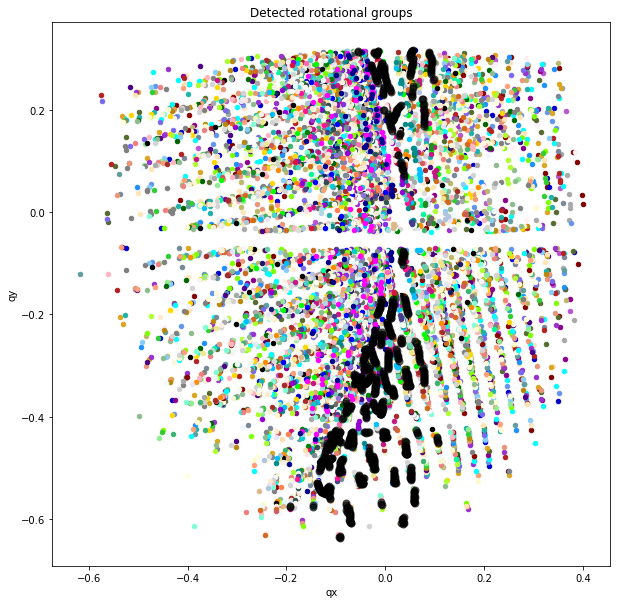

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 10))
color_list = list(colors.CSS4_COLORS.values())[:len(qs_list)]
np.random.shuffle(color_list)
for frame_qs, color in zip(qs_list, color_list):
    plt.scatter(frame_qs.scat_vec[:, 0], frame_qs.scat_vec[:, 1], 20, color)
for group in groups.groups:
    streaks = np.concatenate(group.streaks)
    plt.scatter(streaks[:, 0], streaks[:, 1], 50, 'black', alpha=0.6)
plt.title('Detected rotational groups')
plt.xlabel('qx')
plt.ylabel('qy')
plt.show()

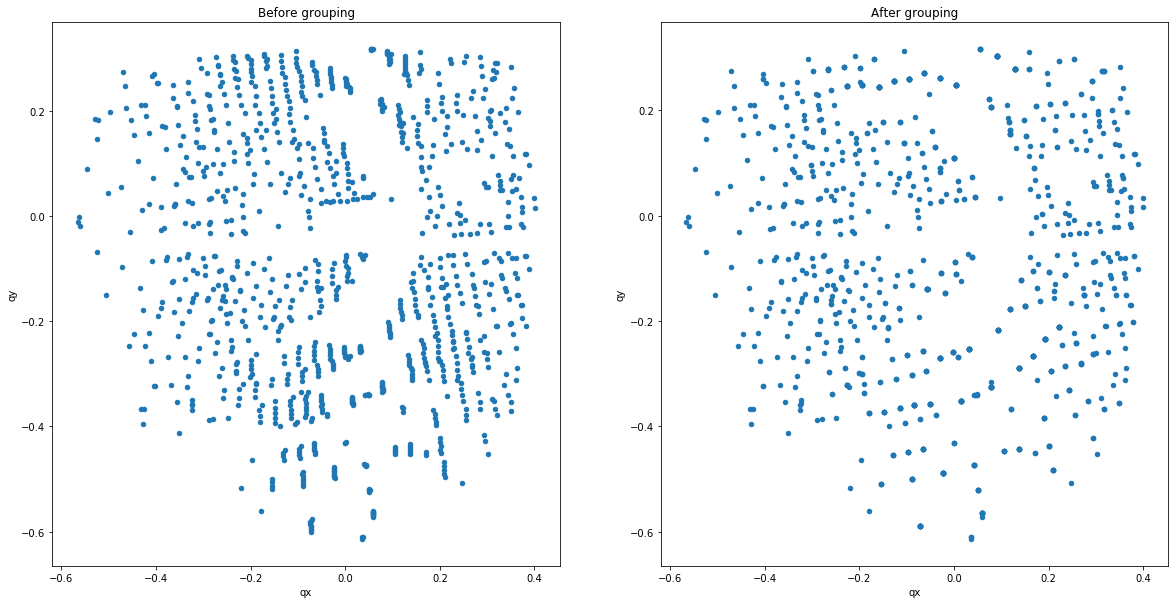

In [227]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(rec_vec.scat_vec[:, 0], rec_vec.scat_vec[:, 1], 20)
axes[0].set_title('Before grouping')
axes[1].scatter(ref_vec.scat_vec[:, 0], ref_vec.scat_vec[:, 1], 20)
axes[1].set_title('After grouping')
for ax in axes:
    ax.set_xlabel('qx')
    ax.set_ylabel('qy')
plt.show()

# Gradien descend

In [4]:
lsd = cbc_dp.LineSegmentDetector(sigma_scale=0.2, scale=0.9)
b12_scan = lsd.det_scan(b12_strks_data, b12_exp)
b12_qs = b12_scan.kout_ref(np.radians(np.arange(101)))
basis_full = b12_qs.index()
rec_basis_full = cbc.rec_basis(basis_full)

In [ ]:
frame_idx = 5
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
q_tf = cbc_dp.QIndexTF(b12_scan[frame_idx].raw_lines.mean(axis=1),
                       1e-10 * np.ones(12))

size_bounds = np.stack((0.95 * b12_rec_sizes, 1.05 * b12_rec_sizes), axis=1)
pts_bounds = np.stack((0.95 * b12_exp.det_pos, 1.05 * b12_exp.det_pos), axis=1)
bounds = [bound for bound in size_bounds] + 9 * [(None, None)] + [bound for bound in pts_bounds]
start_point = np.concatenate((cbc_dp.qindex_point(rec_basis), b12_exp.det_pos))
res = minimize(q_tf, start_point, bounds=bounds)
bfgs_basis = q_tf.rec_basis(res.x)

det_lines = cbc_dp.SquareModel(cbc_dp.RecLattice(bfgs_basis), np.radians(1.2), 0.7).det_pts(b12_exp)
det_pts = cbc_dp.IndexingSolution(bfgs_basis, q_tf.hkl_idxs(res.x)).det_pts(b12_exp)
start_lines = cbc_dp.IndexingSolution(rec_basis, q_tf.hkl_idxs(start_point)).det_pts(b12_exp)
q_tf(res.x) / q_tf(start_point)

In [6]:
q_tf = cbc_dp.QIndexStreaksTF(b12_scan[frame_idx].raw_lines, 1e-10 * np.ones(12))

res = minimize(q_tf, start_point, bounds=bounds)
bfgs_basis = q_tf.rec_basis(res.x)

det_lines_strks = cbc_dp.SquareModel(cbc_dp.RecLattice(bfgs_basis), np.radians(0.8), 0.7).det_pts(b12_exp)
det_pts_strks = cbc_dp.IndexingSolution(bfgs_basis, q_tf.hkl_idxs(res.x)).det_pts(b12_exp)
start_lines_strks = cbc_dp.IndexingSolution(rec_basis, q_tf.hkl_idxs(start_point)).det_pts(b12_exp)
q_tf(res.x) / q_tf(start_point)

0.7953262689800502

In [7]:
res.x[12:], b12_exp.det_pos

(array([110.25001387, 128.24976607, 101.9762405 ]),
 array([110.25 , 128.25 , 101.976]))

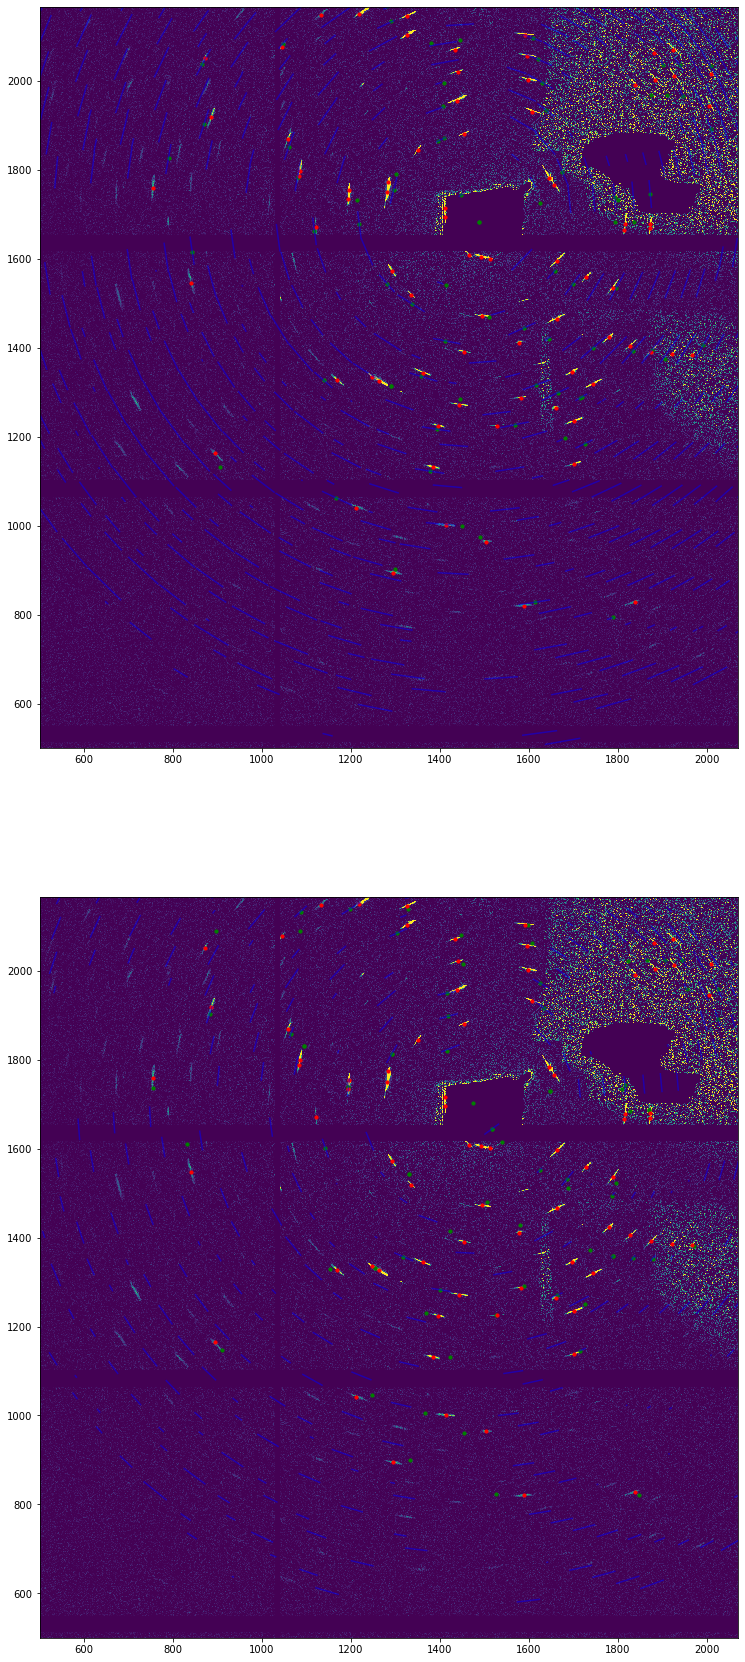

In [8]:
%matplotlib inline
exp_lines = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, axes = plt.subplots(2, 1, figsize=(15, 30))
for ax, lines, pts in zip(axes, [det_lines, det_lines_strks], [det_pts, det_pts_strks]):
    ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
    for line in lines:
        ax.plot(line[:, 0], line[:, 1], 'b', alpha=0.5)
    ax.scatter(pts[:, 0], pts[:, 1], 10, 'g')
    ax.scatter(exp_lines[:, 0], exp_lines[:, 1], 10, 'r')
    ax.set_xlim(500, 2070)
    ax.set_ylim(500, 2167)
plt.show()

In [ ]:
frame_idxs = np.arange(20)

rot_m = b12_exp.rotation_matrix(-np.radians(1.0))
size_bounds = np.stack((0.95 * b12_rec_sizes, 1.05 * b12_rec_sizes), axis=1)
bounds = [bound for bound in size_bounds] + 9 * [(None, None)]

res_list, tf_list, pts_list, start_list = [], [], [], []
for frame_idx in frame_idxs:
    if frame_idx:
        start_point = res_list[-1].dot(rot_m.T)
    else:
        start_point = rec_basis_full
    qs_frame = b12_scan[frame_idx].kout_streaks(theta=0)
    q_tf = cbc_dp.QIndexStreaksTF(qs_frame)
    res = minimize(q_tf, cbc_dp.qindex_point(start_point), bounds=bounds)
    rec_basis = q_tf.rec_basis(res.x)
    det_lines = cbc_dp.IndexingSolution(rec_basis,  q_tf.hkl_idxs(res.x)).det_pts(b12_exp)

    res_list.append(rec_basis)
    start_list.append(start_point)
    tf_list.append(q_tf)
    pts_list.append(det_lines)
pts_list = np.array(pts_list)

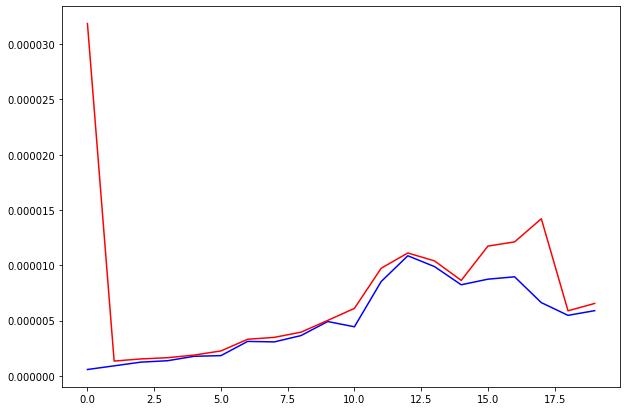

In [57]:
%matplotlib inline
plt.figure(figsize=(10, 7))
plt.plot(frame_idxs, [q_tf(cbc_dp.qindex_point(res)) / 2 for q_tf, res in zip(tf_list, res_list)], 'b')
plt.plot(frame_idxs, [q_tf(cbc_dp.qindex_point(start)) / 2 for q_tf, start in zip(tf_list, start_list)], 'r')
plt.show()

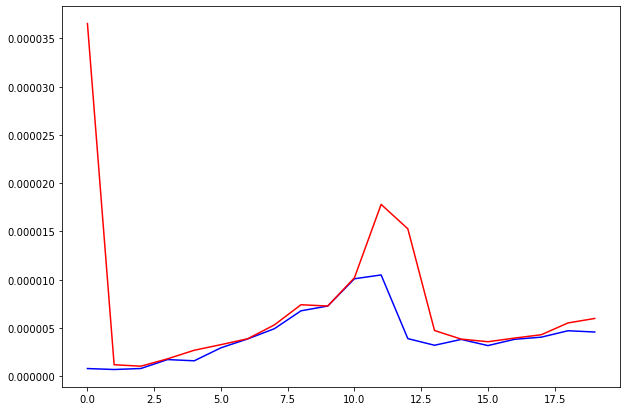

In [16]:
%matplotlib inline
plt.figure(figsize=(10, 7))
plt.plot(frame_idxs, [q_tf(cbc_dp.qindex_point(res)) for q_tf, res in zip(tf_list, res_list)], 'b')
plt.plot(frame_idxs, [q_tf(cbc_dp.qindex_point(start)) for q_tf, start in zip(tf_list, start_list)], 'r')
plt.show()

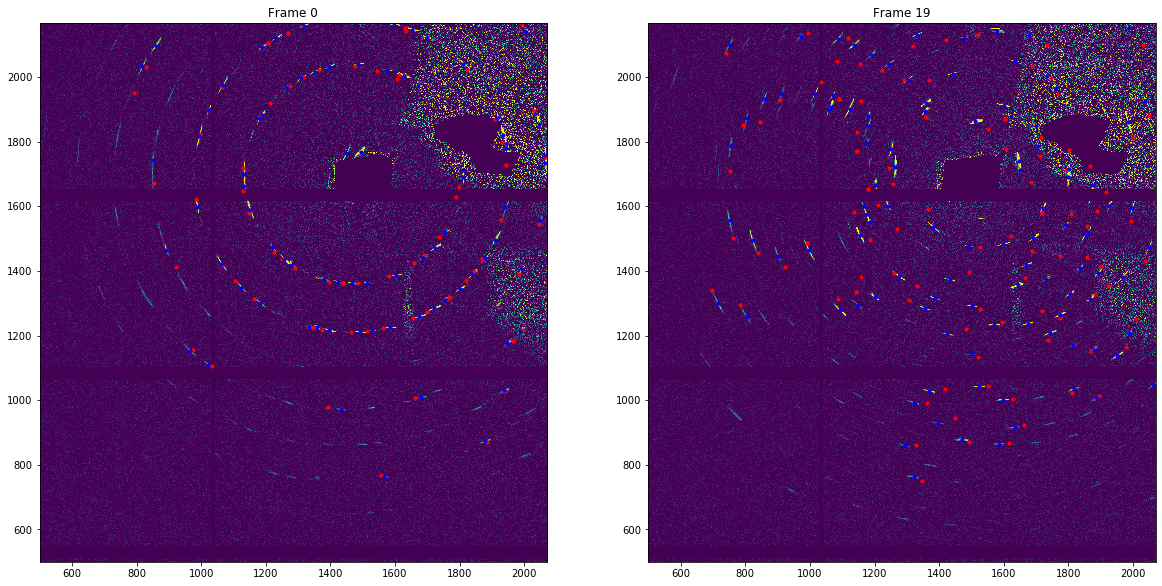

In [27]:
%matplotlib inline
idxs = [0, -1]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for idx, ax, frame_pts in zip(frame_idxs[idxs], axes, pts_list[idxs]):
    exp_pts = b12_scan[idx].raw_lines.mean(axis=1)
    ax.scatter(frame_pts[:, 0], frame_pts[:, 1], 10, 'r')
    ax.scatter(exp_pts[:, 0], exp_pts[:, 1], 10, 'b')
    ax.imshow(b12_cor_data[idx], vmin=0, vmax=50)
    ax.set_title('Frame {:d}'.format(idx))
    ax.set_xlim(500, 2070)
    ax.set_ylim(500, 2167)
plt.show()

# Diffraction simulation

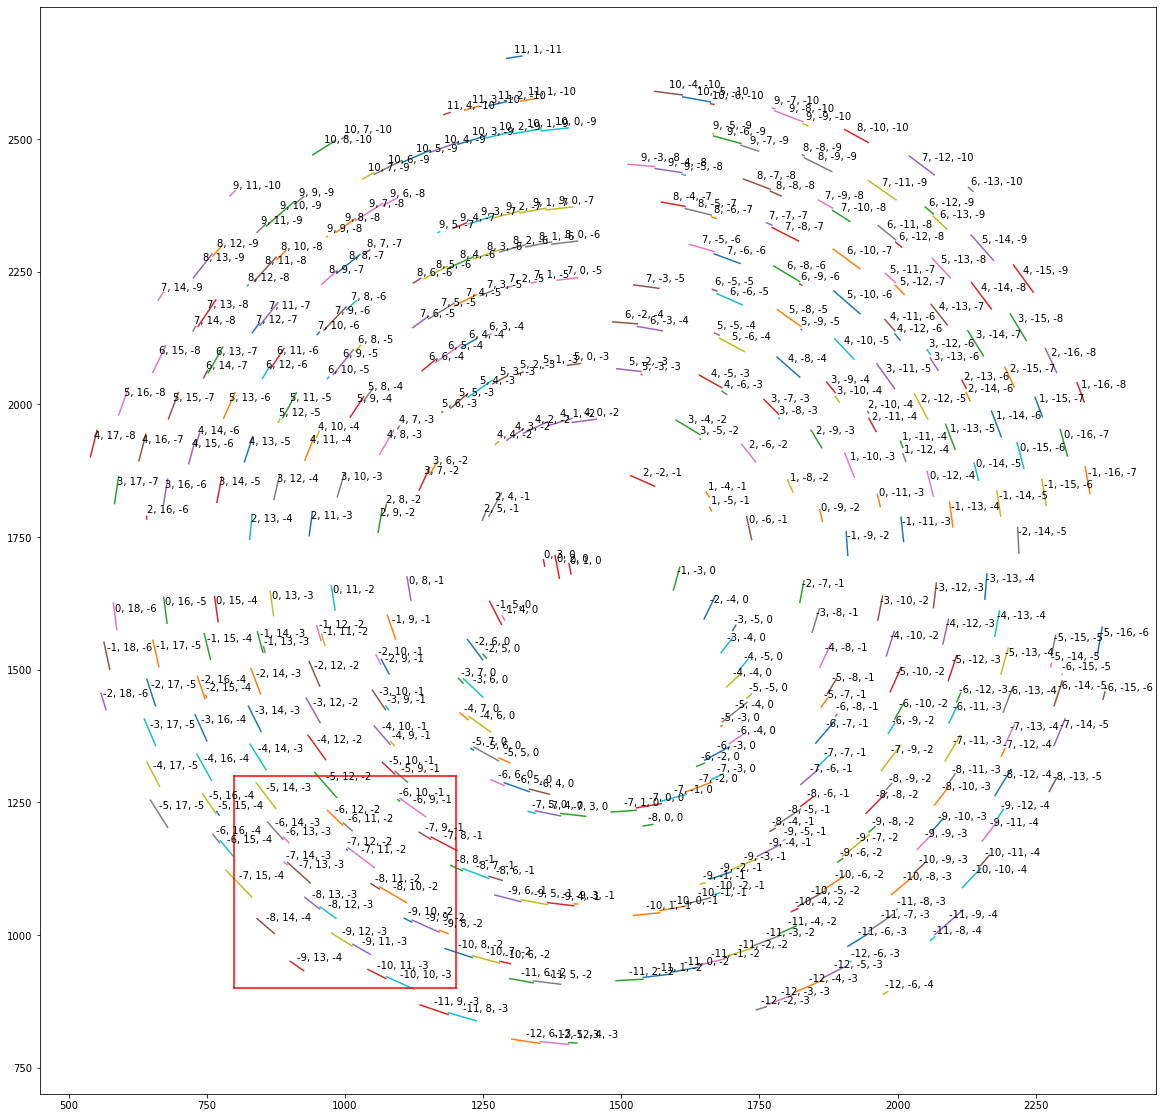

In [28]:
%matplotlib inline
rot_m = cbc_dp.utils.rotation_matrix([1, 0, 0], np.radians(10))
rec_lat = cbc_dp.RecLattice(rec_basis_full.dot(rot_m.T))
model = cbc_dp.SquareModel(rec_lat, np.radians(0.9), 0.6)
det_lines = model.det_pts(b12_exp)
hkl_idxs = model.hkl_idx.astype(np.int64)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
for line, hkl_idx in zip(det_lines, hkl_idxs):
    ax.plot(line[:, 0], line[:, 1])
    ax.text(line[:, 0].mean(), line[:, 1].mean() + 10, '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl_idx))
ax.plot(np.linspace(800, 1200), 900 * np.ones(50), 'r')
ax.plot(np.linspace(800, 1200), 1300 * np.ones(50), 'r')
ax.plot(800 * np.ones(50), np.linspace(900, 1300), 'r')
ax.plot(1200 * np.ones(50), np.linspace(900, 1300), 'r')
plt.show()

In [78]:
mod_scan = []
kins = []
for theta in np.radians(np.arange(101)):
    rot_m = b12_exp.rotation_matrix(-theta)
    or_rot = or_mat.dot(rot_m.T)
    rec_lat = cbc_dp.RecLattice(or_mat=or_rot, center=np.zeros(3))
    model = cbc_dp.CircModel(rec_lat=rec_lat, num_ap=np.radians(1.5), q_max=0.4)
    xs, ys = model.detector_pts(b12_dist)
    lines = np.stack((xs, ys), axis=2) / pix_size
    kin = np.mean((model.entry_pts(), model.exit_pts()), axis=0).T
    kins.append(kin.dot(rot_m))
    strks = cbc_dp.FrameStreaks(lines, np.zeros(2))
    mod_scan.append(strks)
mod_scan = cbc_dp.ScanStreaks(mod_scan)
kins = np.concatenate(kins)
mod_qs_ref = mod_scan.kout_ref(exp_set=b12_exp,
                               theta=np.radians(np.arange(101)),
                               pixels=35)
mod_qs_raw = mod_scan.kout(exp_set=b12_exp,
                           theta=np.radians(np.arange(101)))
mod_qs = cbc_dp.RecVectors(kout=mod_qs_raw.kout, kin=kins)
rec_lat = cbc_dp.RecLattice(or_mat, np.zeros(3))
qs_model = rec_lat.scat_vec(mod_qs.scat_vec)

In [46]:
%gui qt
app = cbc_dp.Qt.make_app()
w = cbc_dp.Qt.ScatterViewer()
w.set_data(pos=mod_qs.scat_vec, size=5)
w.show()

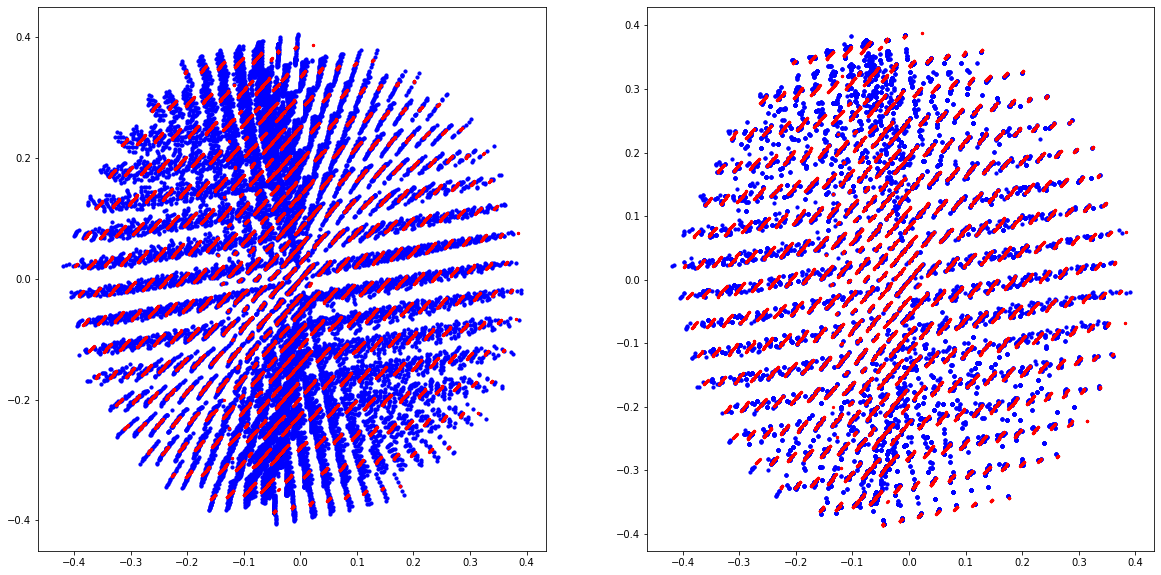

In [79]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(mod_qs_raw.scat_vec[:, 0], mod_qs_raw.scat_vec[:, 1], 10, 'b')
axes[0].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
axes[1].scatter(mod_qs_ref.scat_vec[:, 0], mod_qs_ref.scat_vec[:, 1], 10, 'b')
axes[1].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
plt.show()

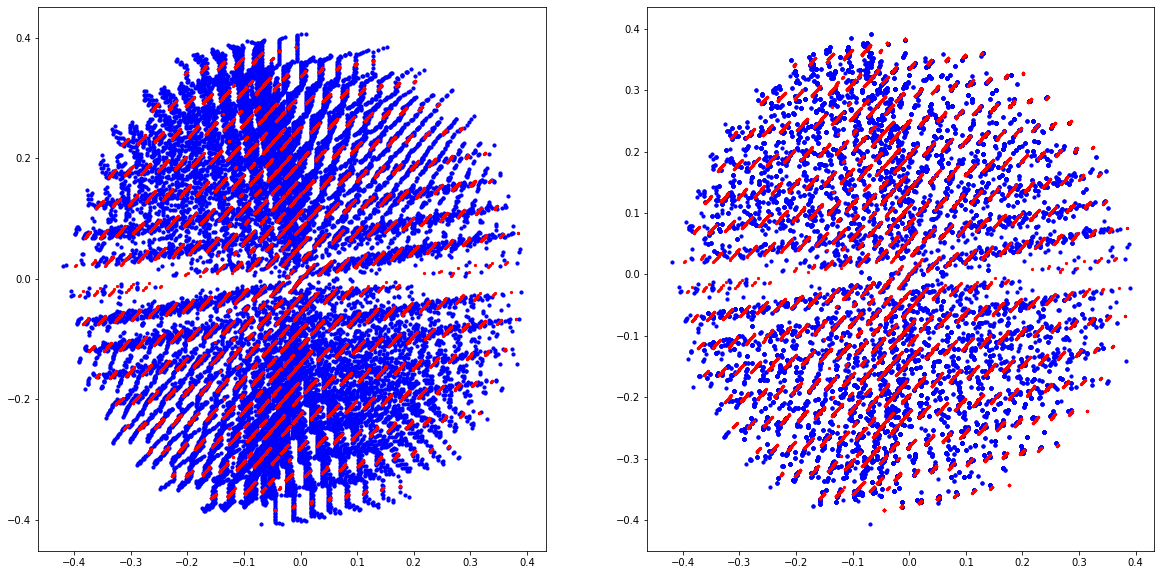

In [93]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(mod_qs_raw.scat_vec[:, 0], mod_qs_raw.scat_vec[:, 1], 10, 'b')
axes[0].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
axes[1].scatter(mod_qs_ref.scat_vec[:, 0], mod_qs_ref.scat_vec[:, 1], 10, 'b')
axes[1].scatter(qs_model[:, 0], qs_model[:, 1], 5, 'r')
plt.show()

In [65]:
def rec_or(axes):
    """
    Return orientation matrix based on unit cell primitive vectors matrix

    axes - unit cell primitive vectors matrix
    """
    a_rec, b_rec, c_rec = cbc.rec_basis(axes[0], axes[1], axes[2])
    return np.stack((a_rec, b_rec, c_rec))

In [85]:
size = 100
gauss_sigma = 4
threshold = 3
fft_grid = mod_qs_ref.fft(size)
fft_blur = gaussian_filter(fft_grid.astype(np.float64), gauss_sigma)
peak_mask = fft_blur > fft_blur.mean() + threshold * fft_blur.std()
peak_labels, peak_num = label(peak_mask)
peak_centers = np.array(maximum_position(fft_blur,
                                         labels=peak_labels,
                                         index=np.arange(1, peak_num + 1)))
peak_centers = peak_centers - size / 2 * np.ones(3)
axes_mask = np.array([center.dot(center) for center in peak_centers]).argsort()[:11]
centers = (peak_centers * mod_qs_ref.range**-1)[axes_mask]
axes = centers[[1, 3, 9]]

In [86]:
mod_or = rec_or(axes)
mod_or, or_mat

(array([[-0.00928437,  0.04533879,  0.00148683],
        [-0.03122388, -0.00544065, -0.00017842],
        [ 0.00171495,  0.00181355, -0.02616825]]),
 array([[-0.00955958,  0.04569071,  0.00127158],
        [-0.03160975, -0.00589558, -0.00016407],
        [-0.00153314, -0.00164234,  0.02641596]]))

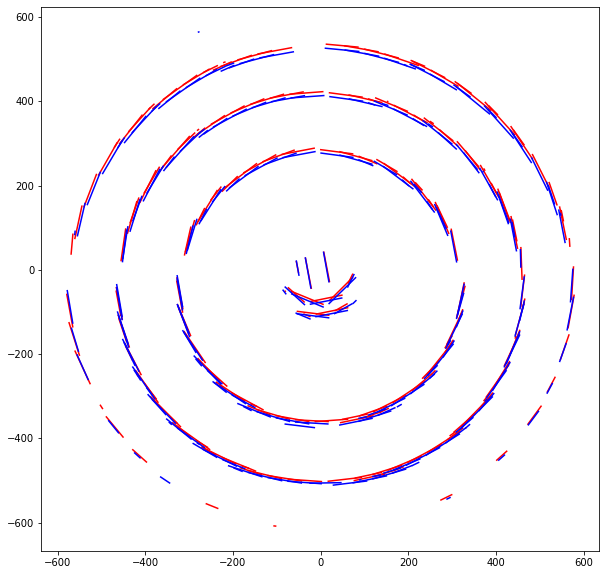

In [91]:
%matplotlib inline
rec_lat = cbc_dp.RecLattice(or_mat=mod_or, center=np.zeros(3))
model = cbc_dp.SquareModel(rec_lat=rec_lat, num_ap=np.radians(1.5), q_max=0.4)
xs, ys = model.detector_pts(b12_dist)
plt.figure(figsize=(10, 10))
for line in mod_scan[0].lines:
    plt.plot(line[:, 0], line[:, 1], 'r')
for x, y in zip(xs, ys):
    plt.plot(x / pix_size, y / pix_size, 'b')
plt.show()

# Peaks sum

In [31]:
lyssum = np.concatenate([lines for lines in lyslines if lines.any()]).mean(axis=1)
b12sum = np.concatenate([lines for lines in b12lines if lines.any()]).mean(axis=1)
lyssumints = np.concatenate([ints for ints in lysints if ints.any()])
b12sumints = np.concatenate([ints for ints in b12ints if ints.any()])

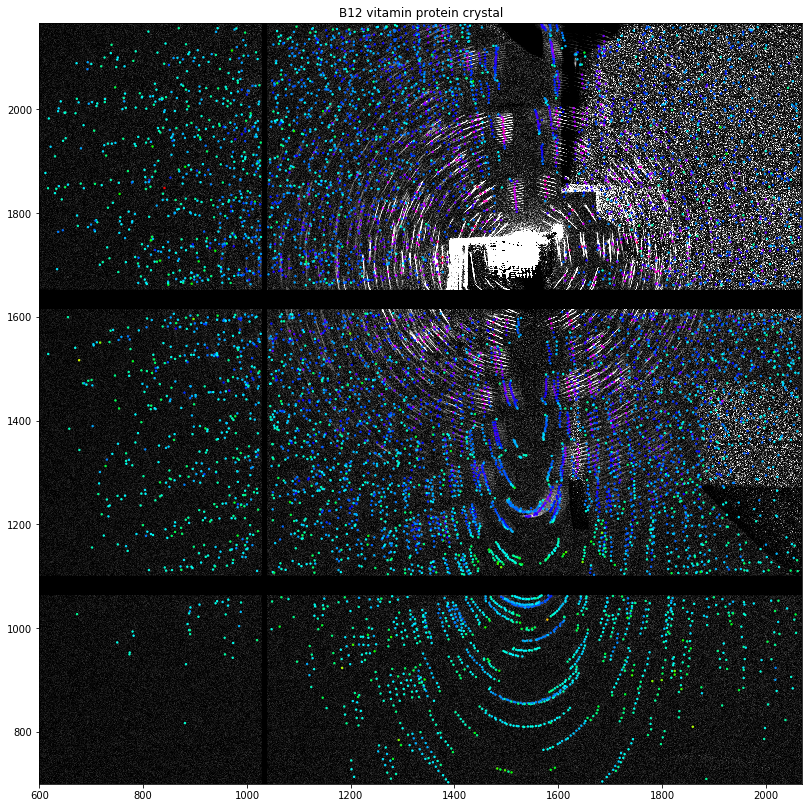

In [32]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(b12data.sum(axis=0), vmin=0, vmax=3000, cmap='gist_gray')
plt.scatter(b12sum[:, 0], b12sum[:, 1], s=2, c=np.log(b12sumints - b12sumints.min() + 1.0), cmap='hsv')
plt.xlim((b12roi.roi[2], b12roi.roi[3]))
plt.ylim((b12roi.roi[0], b12roi.roi[1]))
plt.title('B12 vitamin protein crystal')
plt.show()

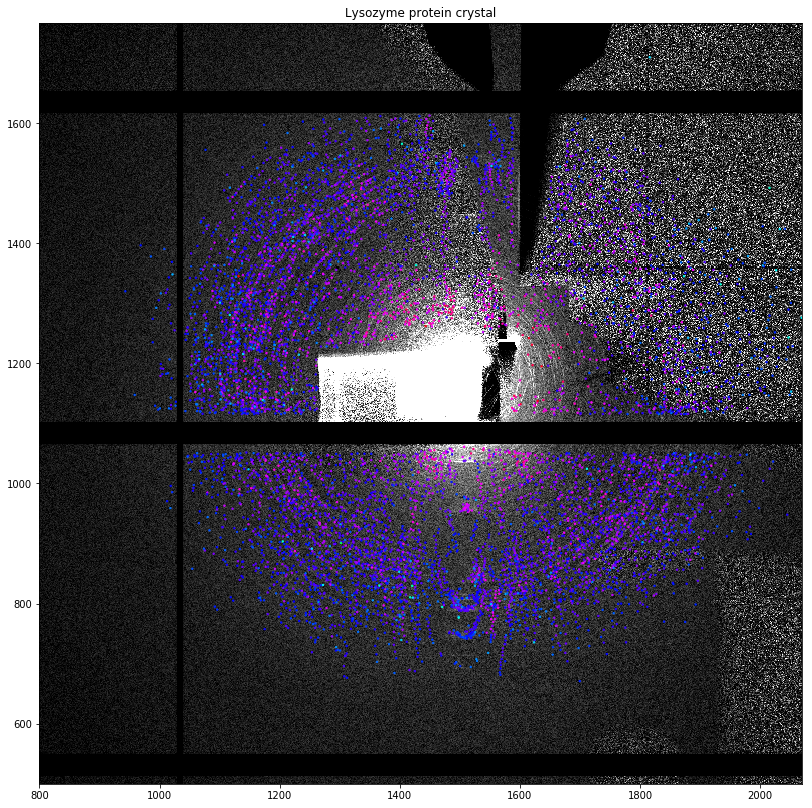

In [86]:
%matplotlib inline
plt.figure(figsize=(14, 14))
plt.imshow(lysdata.sum(axis=0), vmin=100, vmax=3000, cmap='gist_gray')
plt.scatter(lyssum[:, 0], lyssum[:, 1], s=2, c=np.log(lyssumints - lyssumints.min() + 1.0), cmap='hsv')
plt.xlim((lysroi.roi[2], lysroi.roi[3]))
plt.ylim((lysroi.roi[0], lysroi.roi[1]))
plt.title('Lysozyme protein crystal')
plt.show()